<a href="https://colab.research.google.com/github/amaneth/Multinomial-Naive-Bayes/blob/main/Multinomial_naive_bayes_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multinomial Naives Bayes

In [150]:

import numpy as np
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [151]:
movie_df= pd.read_csv('/content/sample_data/IMDB Dataset.csv')
movie_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [152]:
import re
class MultinomialBN():
  def __init__(self,k):
    self.k=k
    self.documents=None
    self.labels=None
    self.vocublary={}
    self.num_classes = 2
    self.prior=None
    self.likelihood=None
    self.stop_words = set(stopwords.words('english'))
  
  def tokenize(self, documents, train=True):
    '''
    args: 
      documents: The documents to tokenized
      train: the mode of tokenizing, in test mode we don't add new words to the vocublary

    returns: a list of documents lemantized
    '''
    tokenized_docs=[]
    stemmer = SnowballStemmer(language = 'english')
    lemmantizer = WordNetLemmatizer()
    id=0
    for document in documents:
      words =re.sub('[^A-Za-z ]+', '', document).split()
      tokenized_doc=[]
      for word in words:
        if word.lower() not in self.stop_words:
          stemized= stemmer.stem(word.lower(),) 
          lemantized= lemmantizer.lemmatize(stemized,)
          # lemantized=word.lower()
          if train:
            if lemantized not in self.vocublary:
              self.vocublary[lemantized]=id
              id+=1
          tokenized_doc.append(lemantized)
      tokenized_docs.append(tokenized_doc)
    return tokenized_docs

  def count_words(self, documents, labels):
    """
      args:
      documents: array of tokenized documents
      labels: categories of the documents
      returns: 
        counts : a maxtrix that represents the frequency of each word in each category
    """

    counts = np.zeros((len(self.vocublary), self.num_classes))
    for document, label in zip(documents,labels):
      for word in document:
        if word in self.vocublary.keys():
          counts[self.vocublary[word]][label] += 1
     
    return counts

  def transform(self, documents):
    """
    args: 
        documents: a pandas series of documents
    returns:
        sparse: a matrix of occurence of each word in each categore for each document
    """
    sparse= np.zeros((len(documents), len(self.vocublary)))
    documents= self.tokenize(documents, train=False)
    for i, document in enumerate(documents):
      for word in document:
        if word in self.vocublary.keys():
          sparse[i][self.vocublary[word]]=1
    return sparse




  def prior_probablity(self):
    #returns the prior probablity of each class
    prior_probabilities = np.zeros(self.num_classes)
    total_documents = len(self.labels)

    for cat in range(self.num_classes):
      prior_probabilities[cat] = self.labels.value_counts()[cat]/total_documents

    self.prior = prior_probabilities


  def likelihood_probablity(self, counts):
    """
    args:
        counts: the count maxtrix of frequency of each word in the document
    """
    vocabulary_size = len(self.vocublary)
    word_probablities=np.zeros((vocabulary_size, self.num_classes))
    category_count=np.sum(counts,axis=0)

    category_count= category_count+ self.k*vocabulary_size
    counts = counts+self.k
    word_probablities=counts/category_count
    self.likelihood=word_probablities

  def fit(self, X, y):
    #fit the the train data to the model
    self.documents = self.tokenize(X, train=True)
    classes=y.unique()
    self.num_classes=len(classes)
    self.labels = y.map(lambda x: np.where(classes==x)[0][0])
  
    counts = self.count_words(self.documents, self.labels)
    self.prior_probablity()
    self.likelihood_probablity(counts)
    

  def predict(self, X, batch_size=500):
    #returns the prediction of categories for a test document
    batches=(len(X)//batch_size)+1
    predictions=[]
    for batch in range(batches):
      X_new=X[batch*batch_size:(batch+1)*(batch_size)]
      X_new= self.transform(X_new)
      log_probablity= X_new[..., np.newaxis]*np.log(self.likelihood[np.newaxis,...])
      cat_log_probablity= log_probablity.sum(axis=1)

      category_probablity = np.log(self.prior) + cat_log_probablity
      prediction=np.argmax(category_probablity,axis=1)
      predictions.extend(prediction)
    return predictions


  def accuracy(self, y, yPred):
    #returns the accuracy of the model in percentage
    return (np.sum(y == yPred)/len(y))*100


In [153]:
transformer=MultinomialBN(k=1)

In [154]:
ratio = 0.8
size = len(movie_df)
train_size = int(ratio * size)
print(train_size)
X_train, y_train = movie_df['review'][:train_size], movie_df['sentiment'][:train_size]
X_test, y_test = movie_df['review'][train_size:], movie_df['sentiment'][train_size:]
cats = movie_df['sentiment'].unique().tolist()
y_test = y_test.apply(lambda x : cats.index(x))

40000


In [155]:
transformer.fit(X_train, y_train)

In [156]:
ypred=transformer.predict(X_test)

In [157]:
transformer.accuracy(ypred, y_test)

85.79

## Result analysis

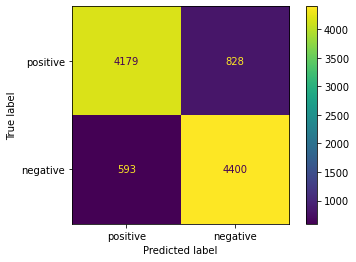

In [158]:

cm = confusion_matrix(y_test, ypred,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cats)
disp.plot()

In [159]:
df2 = pd.read_csv('/content/sample_data/mnb.csv')
df2.head()

,Unnamed: 0,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,0,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.390000e+12
1,1,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.390000e+12
2,2,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.390000e+12
3,3,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.390000e+12
4,4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.390000e+12


In [160]:
new_transformer = MultinomialBN(k=1)

In [161]:
ratio = 0.8
size = len(df2)
train_size = int(ratio * size)
print(train_size)
X_train2, y_train2 = df2['TITLE'][:train_size], df2['CATEGORY'][:train_size]
X_test2, y_test2 = df2['TITLE'][train_size:], df2['CATEGORY'][train_size:]
cats = df2['CATEGORY'].unique().tolist()
y_test2 = y_test2.apply(lambda x : cats.index(x))


52


In [162]:
X_test2.shape

(13,)

In [163]:
new_transformer.fit(X_train2, y_train2)

In [164]:
yPred = new_transformer.predict(X_test2)

In [165]:
yPred

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [166]:
new_transformer.accuracy(yPred, y_test2)

100.0

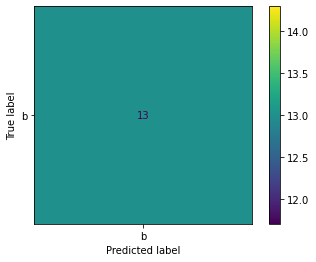

In [167]:
cm = confusion_matrix(y_test2, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cats)
disp.plot()

<h1>Compare result with Scikit learn result</h1>

In [168]:
stemmer = SnowballStemmer(language = 'english')
lem = WordNetLemmatizer()
stop = set(stopwords.words('english'))

def tokenize(document):
  document = document.lower()
  data = [char for char in document if char not in string.punctuation]
  data = ''.join(data)
  data = [word for word in data.split() if word.lower() not in stop]
  data = [stemmer.stem(x,) for x in data]
  data = [lem.lemmatize(x,) for x in data]
  return data

In [169]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [170]:

# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df2['TITLE'])

encoder = LabelEncoder()
y = encoder.fit_transform(df2['CATEGORY'])

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_predicted = nb.predict(x_test)

accuracy_score(y_test, y_predicted) 

1.0

In [171]:
# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(movie_df['review'])

encoder = LabelEncoder()
y = encoder.fit_transform(movie_df['sentiment'])

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_predicted = nb.predict(x_test)

accuracy_score(y_test, y_predicted) 

0.848


<h1>Conclusion</h1>

We can see that our code perform as well as their code, but it is a bit slow.